# Network Training
Having implemented and tested all the components of the final networks in steps 1-3, we are now ready to train the network on a large dataset (ImageNet).

In [1]:
import gc
import datetime

import pandas as pd
import numpy as np

from copy import deepcopy
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras import backend as K

import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output

from libs.pconv_model import PConvUnet
from libs.util import random_mask

%load_ext autoreload
%autoreload 2
plt.ioff()

# SETTINGS
TRAIN_DIR = "/var/www2/trinh/Edited_Generative_Inpainting/training_data/training"
VAL_DIR = "/var/www2/trinh/Edited_Generative_Inpainting/training_data/validation"
TEST_DIR = "/var/www2/trinh/Edited_Generative_Inpainting/training_data/testing"


MASK_NOISE = "/var/www2/trinh/Edited_Generative_Inpainting/test_dir/GOPR0076/mask/mask.jpg"

BATCH_SIZE = 4

Using TensorFlow backend.


# Creating train & test data generator

In [2]:
class DataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)
        while True:
            
            # Get augmentend image samples
            ori = next(generator)

            # Get masks for each image sample
            mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori

    def flow_from_directory_for_test(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)
        while True:
            
            # Get augmentend image samples
            ori = next(generator)

            # Get masks for each image sample
            # mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)
            
            image_mask = cv2.imread(MASK_NOISE)
            image_mask = cv2.resize(image_mask,(512,512))
            image_mask[image_mask <=128] = 128
            image_mask[image_mask > 128] = 0
            image_mask[image_mask > 0] = 255
            
            
            mask = np.stack([image_mask for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori            
            
# Create training generator
train_datagen = DataGenerator(  
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip =True
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(512, 512), batch_size=BATCH_SIZE
)

# Create validation generator
val_datagen = DataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR, target_size=(512, 512), batch_size=BATCH_SIZE, seed=1
)

# Create testing generator
test_datagen = DataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory_for_test(
    TEST_DIR, target_size=(512, 512), batch_size=BATCH_SIZE, seed=1
)

Found 2037 images belonging to 3 classes.


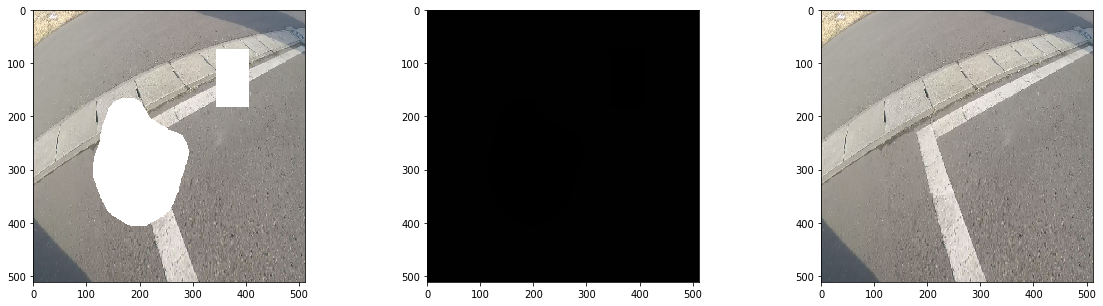

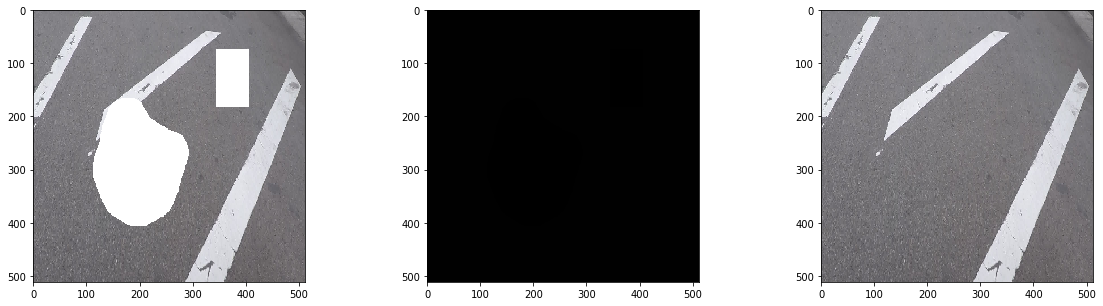

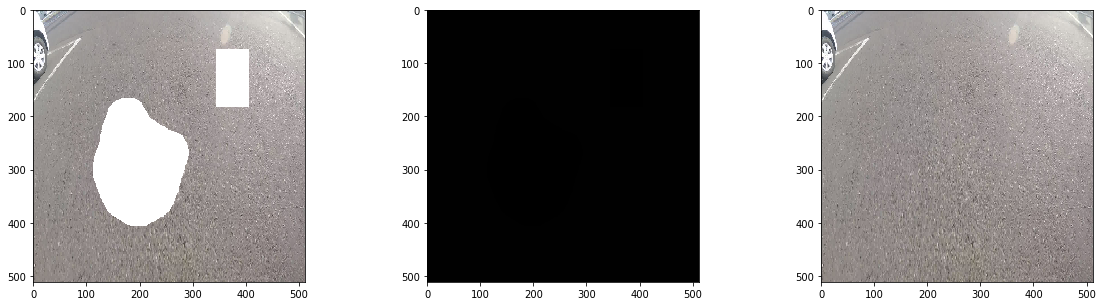

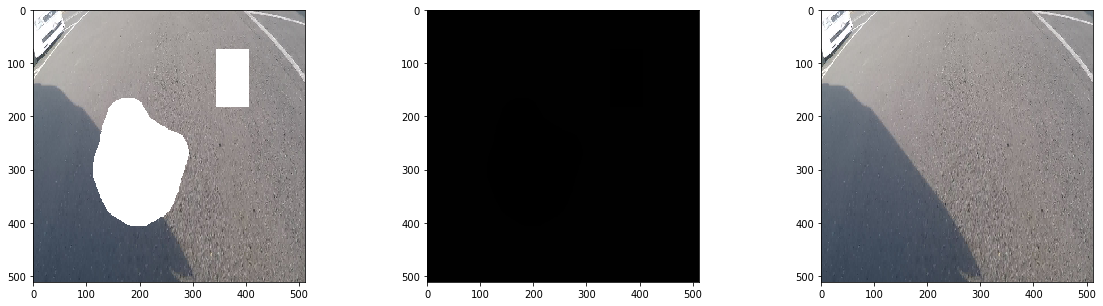

In [3]:
# Pick out an example
test_data = next(test_generator)
(masked, mask), ori = test_data

# Show side by side
for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(mask[i,:,:,:] * 1.)
    axes[2].imshow(ori[i,:,:,:])
    plt.show()

# Training on ImageNet

In [4]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
                
        plt.savefig(r'data/test_samples/img_{}_{}.png'.format(i, pred_time))
        plt.close()

## Phase 1 - with batch normalization

In [5]:
# Instantiate the model
model = PConvUnet(weight_filepath='data/logs/')
model.load("data/logs/85_weights_2018-08-04-11-30-41.h5")

# model.load(r"C:\Users\MAFG\Documents\Github-Public\PConv-Keras\data\logs\50_weights_2018-06-01-16-41-43.h5")

KeyboardInterrupt: 

In [ ]:
# Run training for certain amount of epochs
model.fit(
    train_generator, 
    steps_per_epoch=10000,
    validation_data=val_generator,
    validation_steps=100,
    epochs=50,        
    plot_callback=plot_callback,
    callbacks=[
        TensorBoard(log_dir='data/logs/initial_training', write_graph=False)
    ]
)

## Phase 2 - without batch normalization

In [5]:
def get_last_file_name(folder_path):
    """
    Get the last file name in a folder base on the first number in file name
    Only pay attention to files (not folders)

    :param folder_path: folder path to get the last file name
    :return: string of the last file name (or empty string)
    :example: ['101_abc.h5', '92_abc.h5'] -> '101_abc.h5'
    """

    from os import listdir
    from os.path import isfile, join
    only_files = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]

    only_files = sorted(only_files, key=lambda x: int(x.split("_")[0]))

    if only_files:
        return only_files[-1]
    else:
        return ""

In [6]:
last_file_name = get_last_file_name("data/logs/")
last_model_name ="data/logs/" + last_file_name
print(last_model_name)

data/logs/146_weights_2018-08-28-14-44-33.h5


RUN FROM HERE

In [7]:
# Load weights from previous run
model = PConvUnet(weight_filepath='data/logs/')
model.load(
    last_model_name,
    train_bn=False,
    lr=0.00001
)

In [8]:
# Run training for certain amount of epochs
model.fit(
    train_generator, 
    steps_per_epoch=10000,
    validation_data=val_generator,
    validation_steps=100,
    epochs=20,        
    workers=3,
    plot_callback=plot_callback,
    callbacks=[
        TensorBoard(log_dir='data/logs/fine_tuning', write_graph=False)
    ]
)

Epoch 147/147
Found 119616 images belonging to 60 classes.
10000/10000 [==============================] - 10809s 1s/step - loss: 248188.8720 - val_loss: 255581.0680
Epoch 148/148
10000/10000 [==============================] - 10788s 1s/step - loss: 247870.8903 - val_loss: 253613.0258
Epoch 149/149
10000/10000 [==============================] - 10783s 1s/step - loss: 247768.5839 - val_loss: 241709.7644
Epoch 150/150
10000/10000 [==============================] - 10808s 1s/step - loss: 247909.3335 - val_loss: 244453.1227
Epoch 151/151
10000/10000 [==============================] - 10824s 1s/step - loss: 246905.4090 - val_loss: 248137.7870
Epoch 152/152
10000/10000 [==============================] - 10786s 1s/step - loss: 248545.5332 - val_loss: 240732.6823
Epoch 153/153
10000/10000 [==============================] - 10794s 1s/step - loss: 247172.5417 - val_loss: 252192.9553
Epoch 154/154
10000/10000 [==============================] - 10806s 1s/step - loss: 248094.5515 - val_loss: 248851.

KeyboardInterrupt: 